# Synthetic Controls Methodology Test Notebook

## 1. Setup and Imports

In [44]:
import pandas as pd
import numpy as np
import datetime as dt
from geoflex.data import GeoPerformanceDataset
from geoflex.experiment_design import ExperimentDesign
from geoflex.metrics import Metric
from geoflex.methodology.synthetic_controls import SyntheticControls

## 2. Configuration

In [45]:
N_GEOS = 20
N_DAYS_PRE = 60
N_DAYS_POST = 30
TREATMENT_EFFECT = 1.1  # 10% lift
TREATMENT_START_DATE = pd.to_datetime('2025-03-01')
N_TREATMENT_GEOS = 5

## 3. Data Generation

In [48]:
def generate_correlated_pre_experiment_data(
        n_geos: int,
        n_days_pre: int,
        treatment_start_date: int
        ) -> pd.DataFrame:
    """Generates correlated pre-experiment data for multiple geos."""
    geos = [f'G{i+1}' for i in range(n_geos)]
    dates = pd.to_datetime(
        [treatment_start_date - dt.timedelta(days=x) for x in range(1, n_days_pre + 1)]
        )
    
    # Create a common trend
    common_trend = np.random.normal(loc=1000, scale=50, size=n_days_pre)
    
    data_frames = []
    for geo in geos:
        # Add geo-specific noise to the common trend
        geo_sales = common_trend + np.random.normal(loc=0, scale=20, size=n_days_pre)
        df = pd.DataFrame({'date': dates, 'geo_id': geo, 'sales': geo_sales})
        data_frames.append(df)
        
    return pd.concat(data_frames).sort_values(['geo_id', 'date']).reset_index(drop=True)

pre_experiment_df = generate_correlated_pre_experiment_data(
    N_GEOS, N_DAYS_PRE, TREATMENT_START_DATE
    )

print(f"Generated {len(pre_experiment_df)} rows of pre-experiment data.")
pre_experiment_df.head()

Generated 1200 rows of pre-experiment data.


,date,geo_id,sales
0,2024-12-31,G1,1057.285300
1,2025-01-01,G1,1011.527617
2,2025-01-02,G1,1004.581602
3,2025-01-03,G1,1028.206852
4,2025-01-04,G1,991.200936


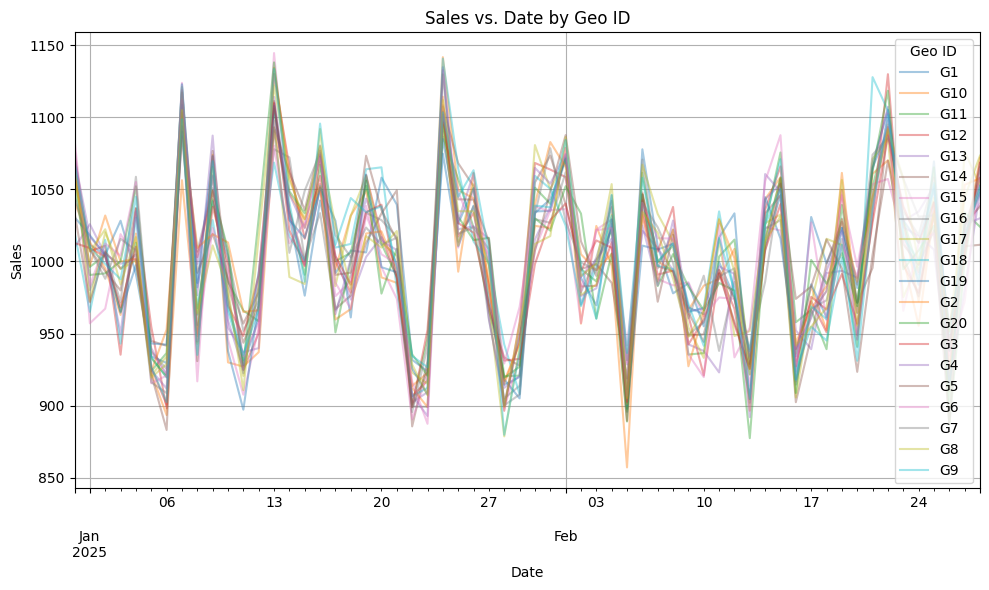

In [49]:
ax = pre_experiment_df.pivot(index='date', columns='geo_id', values='sales').plot(
    figsize=(10, 6),
    title='Sales vs. Date by Geo ID',
    alpha=0.4
)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title='Geo ID')
plt.tight_layout()

## 4. Methodology Setup

In [50]:
geo_data = GeoPerformanceDataset(
    data=dummy_df, geo_id_column='geo_id', date_column='date'
    )

experiment_design = ExperimentDesign(
    primary_metric=Metric(name='sales'),
    methodology='SyntheticControls',
    runtime_weeks=4,
    methodology_parameters={"min_treatment_geos": 2, "num_iterations": 100}
)

sc_method = SyntheticControls()

## 5. Geo Assignment

In [51]:
pretest_geo_data = GeoPerformanceDataset(
    data=pre_experiment_df, geo_id_column='geo_id', date_column='date'
    )

geo_assignment, _ = sc_method._methodology_assign_geos(
    experiment_design=experiment_design,
    historical_data=pretest_geo_data
)
experiment_design.geo_assignment = geo_assignment

print(f"Assigned Treatment Geos: {geo_assignment.treatment}")
print(f"Assigned Control Geos: {geo_assignment.control}")

Assigned Treatment Geos: [{'G18', 'G17', 'G9', 'G13', 'G5', 'G14', 'G19', 'G15', 'G11', 'G8', 'G16'}]
Assigned Control Geos: {'G7', 'G4', 'G2', 'G6', 'G20', 'G1', 'G12', 'G10', 'G3'}


## 6. Generate Post-Experiment Data and Combine

In [52]:
def generate_post_experiment_data(
        n_geos: int,
        n_days_post: int,
        treatment_start_date: str,
        treatment_effect: float,
        assigned_treatment_geos: list[str]
        ) -> pd.DataFrame:
    """Generates post-experiment data and applies a lift to the treatment group."""
    geos = [f'G{i+1}' for i in range(n_geos)]
    dates = pd.to_datetime(
        [treatment_start_date + dt.timedelta(days=x) for x in range(n_days_post)]
        )
    
    common_trend = np.random.normal(loc=1000, scale=50, size=n_days_post)
    
    data_frames = []
    for geo in geos:
        geo_sales = common_trend + np.random.normal(loc=0, scale=20, size=n_days_post)
        df = pd.DataFrame({'date': dates, 'geo_id': geo, 'sales': geo_sales})
        data_frames.append(df)
        
    post_df = pd.concat(data_frames).sort_values(['geo_id', 'date']).reset_index(drop=True)
    
    # Apply treatment effect
    is_treatment_geo = post_df['geo_id'].isin(assigned_treatment_geos)
    post_df.loc[is_treatment_geo, 'sales'] *= treatment_effect
    
    return post_df

assigned_treatment_geos = list(geo_assignment.treatment[0])
post_experiment_df = generate_post_experiment_data(
    N_GEOS, N_DAYS_POST, TREATMENT_START_DATE, TREATMENT_EFFECT, assigned_treatment_geos
    )

runtime_df = pd.concat([pre_experiment_df, post_experiment_df])
runtime_geo_data = GeoPerformanceDataset(
    data=runtime_df, geo_id_column='geo_id', date_column='date'
    )

print(f"Combined runtime data has {len(runtime_df)} rows.")
post_experiment_df.head()

Combined runtime data has 1800 rows.


,date,geo_id,sales
0,2025-03-01,G1,965.267186
1,2025-03-02,G1,1034.034143
2,2025-03-03,G1,878.953950
3,2025-03-04,G1,979.984142
4,2025-03-05,G1,1071.692321


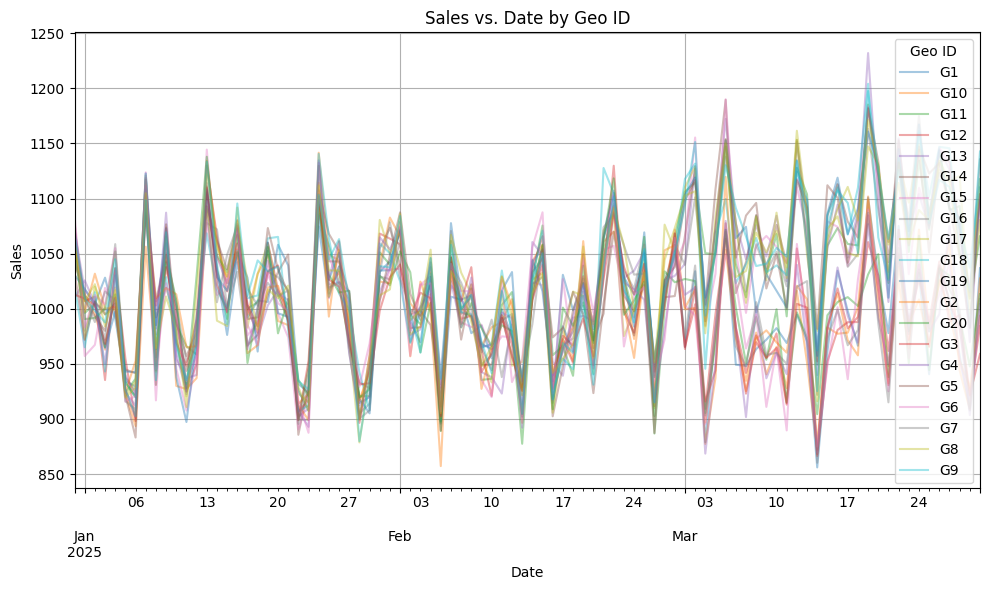

In [53]:
ax = runtime_df.pivot(index='date', columns='geo_id', values='sales').plot(
    figsize=(10, 6),
    title='Sales vs. Date by Geo ID',
    alpha=0.4
)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.grid(True)
ax.legend(title='Geo ID')
plt.tight_layout()

## 7. Experiment Analysis

In [54]:
pretest_end_date = TREATMENT_START_DATE - dt.timedelta(days=1)
experiment_end_date = TREATMENT_START_DATE + dt.timedelta(days=N_DAYS_POST - 1)

results_df, _ = sc_method._methodology_analyze_experiment(
    runtime_data=runtime_geo_data,
    experiment_design=experiment_design,
    experiment_start_date=TREATMENT_START_DATE,
    experiment_end_date=experiment_end_date,
    pretest_period_end_date=pretest_end_date,
)

## 8. Results

In [55]:
print("Analysis Results:")
results_df

Analysis Results:


,point_estimate,lower_bound,upper_bound,point_estimate_relative,lower_bound_relative,upper_bound_relative,p_value,metric
0,94.077048,90.922338,97.231759,<NA>,<NA>,<NA>,7.337858e-30,sales
